In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii
from pathlib import Path
import yt
import sys
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from mpl_toolkits.axes_grid1 import AxesGrid
import pickle
import os
import re
from mpl_toolkits.axes_grid1 import ImageGrid,Grid
from matplotlib import gridspec
from scipy.optimize import curve_fit
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [55]:
path='/gpfs/ckswls1699/grammar/Nx256/time_dependent_gravity'
datapath=Path(path)
t_grav=list(datapath.glob('hii*'))
print(t_grav)

[PosixPath('/gpfs/ckswls1699/grammar/Nx256/time_dependent_gravity/hii_Q51.0n3.0M5')]


In [6]:
s=pa.LoadSim(str(t_grav[0]))
h=pa.read_hst(s.files['hst'])

/home/ckswls1699/pyathena/pyathena/io/read_hst.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  hst = pd.read_csv(filename, names=vlist,


In [23]:
ds=s.load_hdf5(1,load_method='yt')
ad=ds.all_data()

## snapshot of gravity field


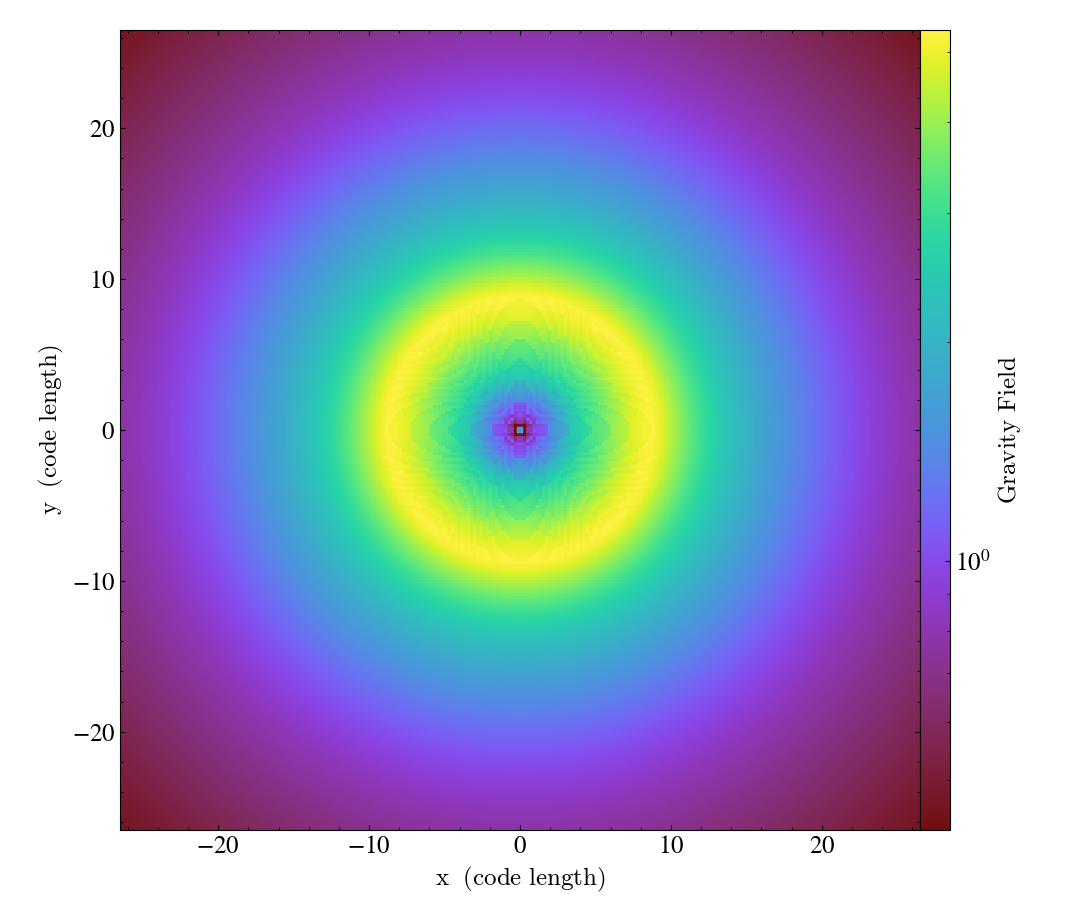

In [45]:
yt.SlicePlot(ds,'z','gravity_field')

## compare real M_neu vs gravity M_neu($r^2g/G$) whlie $t<t_{0,src} -> M_{star}=0$

In [61]:
ds=s.load_hdf5(100,load_method='yt')
ad=ds.all_data()

In [62]:
units=s.par['units']
G_code=(const.G.cgs).value/units['length_cgs']**3*units['mass_cgs']*units['time_cgs']**2

In [63]:
xmin=np.min(np.abs(ad['x']))
r1d=ad['radius'][(ad['z']==xmin)&(ad['y']==xmin)]
grav1d=ad['gravity_field'][(ad['z']==xmin)&(ad['y']==xmin)]

In [93]:
rho=ad['rho']*ad['r0']
dV=ad['cell_volume']
dMneu=rho*dV
rbin=np.linspace(0,np.max(r1d),256)
Mneu=np.array([])
for num in range(len(rbin)):
    Mneu=np.hstack([Mneu,np.sum(dMneu[ad['radius']<=rbin[num]])])

Text(0.5, 0, 'radius')

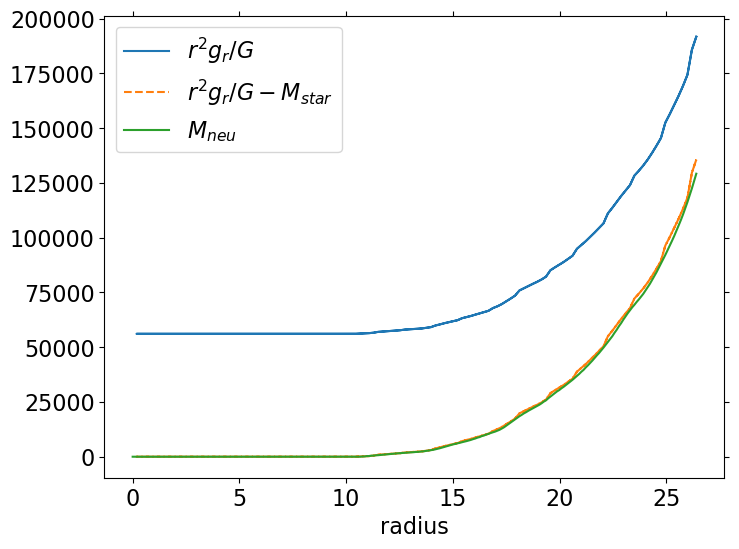

In [97]:
M_g=grav1d*r1d*r1d/G_code
rmin=np.min(r1d)
M_star=M_g[r1d==rmin].value-Mneu[0].value
plt.plot(r1d,M_g,label='$r^2g_r/G$')
plt.plot(r1d,M_g.value-M_star[0],'--',label='$r^2g_r/G-M_{star}$')
plt.plot(rbin,Mneu,label='$M_{neu}$')
plt.legend()
plt.xlabel('radius')
#plt.yscale('log')


## compare real mass star vs gravity mass star

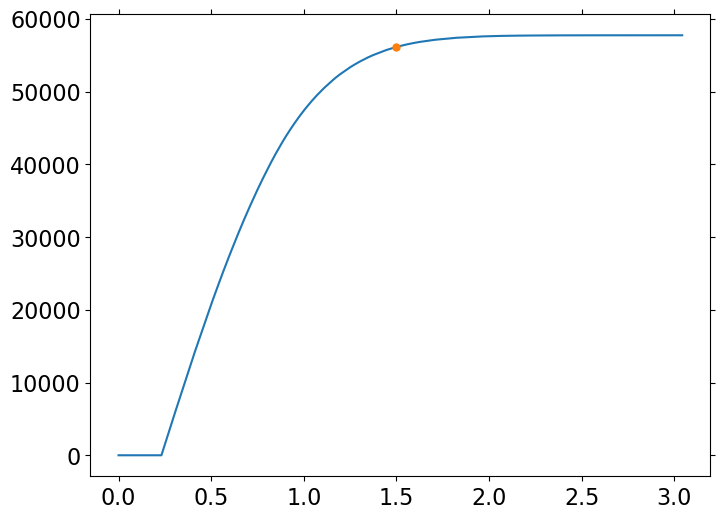

In [90]:
ti=ds.current_time
plt.plot(h['time'],h['mass_star'])
plt.plot(ti,M_star[0],'o',ms=5)

## hst file check: compare total gravity force in hdf5 file vs hst file

In [71]:
f_g_neu=np.sum(ad['gravity_field']*ad['cell_mass']*ad['r0'])
f_g_ion=np.sum(ad['gravity_field']*ad['cell_mass']*(1-ad['r0']))

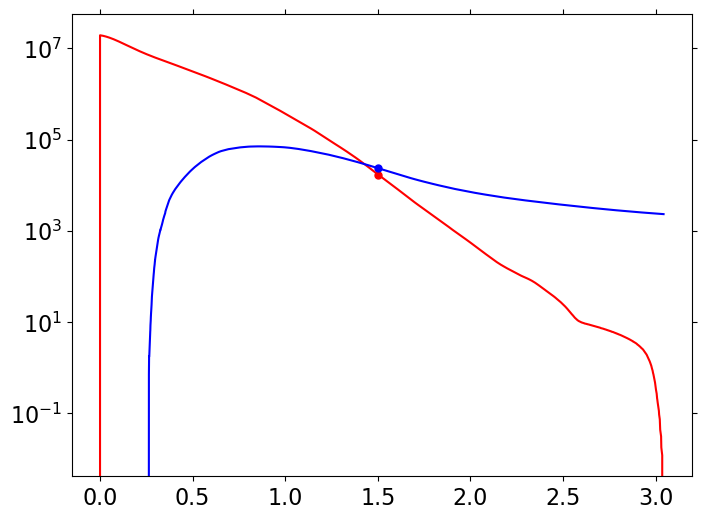

In [77]:
plt.plot(h['time'],-h['force_grav_neu'],'r')
plt.plot(ti,f_g_neu,'ro',ms=5)
plt.plot(h['time'],-h['force_grav_ion'],'b')
plt.plot(ti,f_g_ion,'bo',ms=5)
plt.yscale('log')
plt.xlabel('y')

## rms density

In [102]:
s.par['mesh']['x1max']**3*8

148978.146897728

In [100]:
h['int_sqr_n_ion_dv'],h['vol_ion']

(0        0.0
 1        0.0
 2        0.0
 3        0.0
 4        0.0
         ... 
 21890    inf
 21891    inf
 21892    inf
 21893    inf
 21894    inf
 Name: int_sqr_n_ion_dv, Length: 21895, dtype: float64,
 0             0.0
 1             0.0
 2             0.0
 3             0.0
 4             0.0
            ...   
 21890    148978.0
 21891    148978.0
 21892    148978.0
 21893    148978.0
 21894    148978.0
 Name: vol_ion, Length: 21895, dtype: float64)